# A comparison of 10K corhort thrombolysis rates across hospitals using a combined XGBoost model

A 10K cohort set of patients is set aside, and and XGBoost model trained on the remainder of patients (using one-hot encoding of hospital). Predictions are then made of which of the 10K patients each hospital would give thrombolysis to.

The predicted thrombolysis use at each hospital (for this 10K patient) is saved; later this will be used to select the top hospitals with greatest propensity to use thrombolysis.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Create output folders if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

In [3]:
data_loc = '../data/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

## Combined XGBoost Model

### Train model

In [4]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity = 0)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy}')

Accuracy: 0.852


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [5]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []
single_predictions = []

for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

Sort by hospital 10K thrombolysis rate.

In [6]:
thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', inplace=True, ascending=False)

# Save
thrombolysis_by_hosp.to_csv(
    './output/10k_thrombolysis_rate_by_hosp.csv', index_label='stroke_team')

### Plot thrombolysis rate of 10K cohort at each hospital

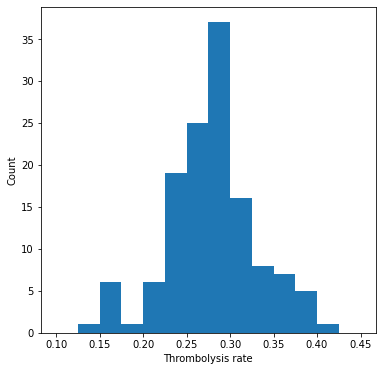

In [7]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [8]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.278
StDev: 0.050
